In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.graph_objects as go
import os
from pprint import pprint

DATA_PATH = r"C:\Users\wilso\Desktop\Sleep-Stage-Classification\src\data_norm\collated.npz"

In [35]:
class Config():
    # Data
    sampling_rate = 100
    x_interval_mins = 30
    x_interval_seconds = x_interval_mins * sampling_rate
    
    # Matplotlib
    default_fig_size = (10,5)

    # Label values
    AWAKE = 0 # Awake
    N1 = 1 # N1
    N2 = 2 # N2
    N3 = 3 # N3
    REM = 4 # REM
    UNKNOWN = 5 # UNKNOWN
    
    label_dict = {
        AWAKE : "W",
        N1 : "A",
        N2 : "B",
        N3 : "C",
        REM : "R",
        UNKNOWN : "U",

        "W" : AWAKE,
        "A" : N1,
        "B" : N2,
        "C" : N3,
        "R" : REM,
        "U" : UNKNOWN,
    }

    stage_name = {
        AWAKE : "AWAKE",
        N1 : "N1",
        N2 : "N2",
        N3 : "N3",
        REM : "REM",
        UNKNOWN : "N5"
    }

    ann2label = {
        "Sleep stage W": 0,
        "Sleep stage 1": 1,
        "Sleep stage 2": 2,
        "Sleep stage 3": 3,
        "Sleep stage 4": 3,
        "Sleep stage R": 4,
        "Sleep stage ?": 5,
        "Movement time": 5
    }

class EEG_Fpz_Cz_Dataset():
    
    def __init__(self, collated_npz_pth, 
                 config=Config()):
        
        self.npz_pth = collated_npz_pth
        self.config = config
        
        data = np.load(self.npz_pth, allow_pickle=True)
        self.file_headers = data.files
        self.x = data["x"]
        self.y = data["y"]
        self.size_arr = list(data["size_arr"])
        
        self.xlen = len(self.x)
        self.ylen = len(self.y)
        self.num_blocks = self.xlen
    
        self.sampling_rate = config.sampling_rate
        self.x_interval_seconds = config.x_interval_seconds
        self.num_data_points = self.xlen * self.x_interval_seconds
        
        self.compressed_y_str = None
        self.compressed_y_ls = None
        self.awakeBlks = None
        self.classCount = None
        self.awakeBlksCount = None
        self.unawakeBlksCount = None
        del data
        
    def getX(self):
        return self.x
    
    def getY(self):
        return self.y
    
    def getCompressedYString(self):
        if self.compressed_y_str is not None: return self.compressed_y_str
        y = self.y
        prev = y[0]
        count = 1
        s = ""
        for i, curr in enumerate(y[1:]):
            if curr == prev:
                count += 1
                continue
            else:
                s += self.config.label_dict[prev] + str(count) + "|"
                count = 1
            prev = curr
        s += self.config.label_dict[prev] + str(count) + "|"
        self.compressed_y_str = s
        return s
    
    def getCompressedY(self):
        if self.compressed_y_ls is not None: return self.compressed_y_ls
        trimmed_y = self.y
        prev = trimmed_y[0]
        count = 1
#         start_idx = config.edge_mins * 2 
        start_idx = 0
        compressed_y_ls = []
        for idx, curr in enumerate(trimmed_y[1:]):
#             idx_w_offset = idx + config.edge_mins * 2 
            idx_w_offset  = idx
            if curr == prev:
                count += 1
                continue
            else:
                compressed_y_ls.append((self.config.label_dict[prev], count, start_idx, idx_w_offset))
                count = 1
                start_idx = idx_w_offset + 1
            prev = curr
        compressed_y_ls.append((self.config.label_dict[prev], count, start_idx, idx_w_offset + 1))
        self.compressed_y_ls = compressed_y_ls
        return compressed_y_ls
    
    def getAwakeBlocksCount(self):
        if self.awakeBlks is not None: return self.awakeBlks
        awakeBlks = []
        for idx, curr in enumerate(self.getCompressedY()):
            if curr[0] == self.config.label_dict[0]:
                awakeBlks.append(curr)
        self.awakeBlks = awakeBlks
        self.awakeBlksCount = len(awakeBlks)
        self.unawakeBlksCount = self.num_blocks - self.awakeBlksCount
        return awakeBlks
    
    def getBlocksCount(self, class_):
        if self.awakeBlks is not None: return self.awakeBlks
        blks = []
        for idx, curr in enumerate(self.getCompressedY()):
            if curr[0] == self.config.label_dict[class_]:
                blks.append(curr)
        return blks
    
    def getClassCount(self):
        if self.classCount is not None: return self.classCount
        unique, counts = np.unique(self.y, return_counts=True)
        total = sum(counts)
        count_tuple = tuple(zip(counts, counts / total * 100))
        ret = dict(zip(unique, count_tuple))
        ret["total"] = total
        self.classCount = ret
        return self.classCount
    
    def getClassHist(self):
        h = {key:self.getClassCount()[key] for key in list(range(0,5))}
        counts, percentages = list(zip(*h.values()))
        plt.figure(figsize=self.config.default_fig_size)
        plt.bar([*h.keys()], counts)
        plt.title('Sleep Stage Count Histogram')
        plt.xlabel('Sleep Stage')
        plt.ylabel('Count')
        plt.show()
    
    def getSleepStagePlot(start_idx, end_idx):
        print("To-Do")
        
    def generateFullSleepStagePlot(self):
        print("Plot generation will take some time...")
        print("Please use getSleepStagePlot() to generate desired indexes.")
        fig, (ax1, ax2) = plt.subplots(2, figsize=(18,10))
        fig.suptitle("Sleep Stage Plots")

        plt.sca(ax1)
        plt.xticks(np.arange(0, len(self.y)+1, 20))
        plt.yticks(np.arange(0, 5))
        ax1.plot(range(len(self.y)), self.y)

        ax2.plot(range(self.xlen * self.x_interval_seconds), self.x.reshape(-1))
        plt.show()
        
    def getBlockPlot(self, blk_no):
        assert blk_no >= 0, "negative blk_no {blk_no} is invalid"
        assert blk_no < self.xlen, f"Invalid blk_no, max blk_no is {self.num_blocks-1}"
        fig = plt.figure(figsize=(18,5))
        plt.title(f"Block {blk_no} | Sleep Stage : {self.config.stage_name[self.y[blk_no]]}")
        plt.plot(range(self.x_interval_seconds), self.x[blk_no])

In [36]:
collated_data = EEG_Fpz_Cz_Dataset(DATA_PATH)
print(collated_data.x.shape) # x shape
print(collated_data.y.shape) # y shape
print(collated_data.size_arr) # Size of individual records making up the collated record.
print(collated_data.getBlocksCount(0)[:5])
print(collated_data.getBlocksCount(1)[:5])
print(collated_data.getBlocksCount(2)[:5])
print(collated_data.getBlocksCount(3)[:5])
print(collated_data.getBlocksCount(4)[:5])

(42308, 3000)
(42308,)
[841, 1127, 1103, 1186, 1025, 1009, 952, 911, 1235, 1200, 672, 1246, 843, 1016, 976, 1273, 1134, 1054, 1132, 1105, 1104, 1092, 928, 802, 1052, 977, 1028, 1004, 952, 952, 1762, 1144, 1003, 1002, 1773, 964, 920, 1535, 1274]
[('W', 60, 0, 59), ('W', 1, 99, 99), ('W', 1, 421, 421), ('W', 1, 556, 556), ('W', 16, 561, 576)]
[('A', 4, 60, 63), ('A', 1, 128, 128), ('A', 1, 219, 219), ('A', 6, 267, 272), ('A', 4, 282, 285)]
[('B', 13, 64, 76), ('B', 1, 78, 78), ('B', 2, 102, 103), ('B', 7, 114, 120), ('B', 2, 122, 123)]
[('C', 1, 77, 77), ('C', 20, 79, 98), ('C', 2, 100, 101), ('C', 10, 104, 113), ('C', 1, 121, 121)]
[('R', 29, 238, 266), ('R', 29, 389, 417), ('R', 8, 530, 537), ('R', 17, 539, 555), ('R', 33, 679, 711)]


Plot generation will take some time...
Please use getSleepStagePlot() to generate desired indexes.


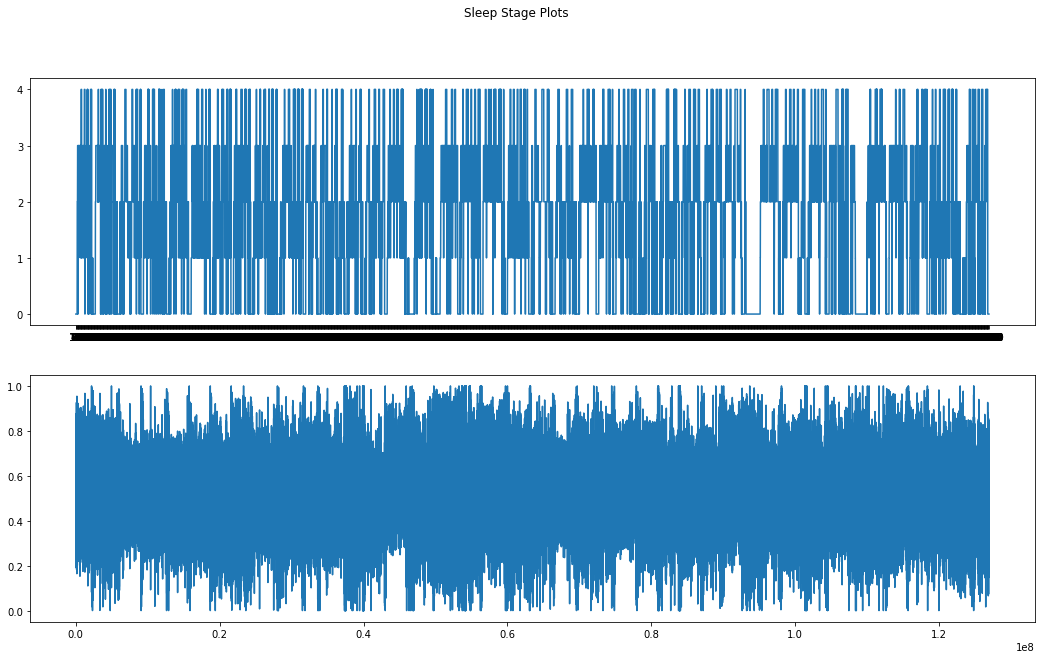

In [37]:
collated_data.generateFullSleepStagePlot()

In [38]:
# data_subset = EEG_Fpz_Cz_Dataset(DATA_PATH)
SUBSET_DATASIZE = 941
subX = collated_data.x[:SUBSET_DATASIZE]
subY = collated_data.y[:SUBSET_DATASIZE]
print(f"X shape: {subX.shape} | Y shape: {subY.shape}")

X shape: (941, 3000) | Y shape: (941,)


Value at index 0:	(-0.588116466999054-0.11977068334817886j) 
Value at index 450:	(0.033285997807979584+0.1635962277650833j)
Value at index 1:	(0.4424183964729309+0.11943273991346359j) 
Value at index 449:	(-0.23465323448181152+0.05942792817950249j)


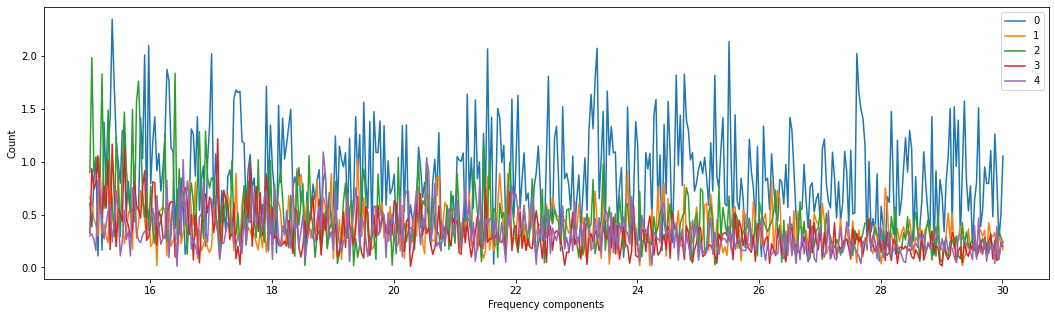

In [39]:
from scipy.fft import fft, ifft
config = Config()
freq = 100 # Sampling rate : 100 samples per s
N = 3000 # Number of points

TEST_IDX0 = 30
TEST_IDX1 = 62
TEST_IDX2 = 70
TEST_IDX3 = 85
TEST_IDX4 = 400

# 30 idxes for every 1 hz
PLT_IDX_LOW = 15*30
PLT_IDX_HIGH = 30*30

xf0 = fft(subX[TEST_IDX0])[PLT_IDX_LOW:PLT_IDX_HIGH+1]
xf1 = fft(subX[TEST_IDX1])[PLT_IDX_LOW:PLT_IDX_HIGH+1]
xf2 = fft(subX[TEST_IDX2])[PLT_IDX_LOW:PLT_IDX_HIGH+1]
xf3 = fft(subX[TEST_IDX3])[PLT_IDX_LOW:PLT_IDX_HIGH+1]
xf4 = fft(subX[TEST_IDX4])[PLT_IDX_LOW:PLT_IDX_HIGH+1]
freq_rng = np.linspace(0, freq, N)[PLT_IDX_LOW:PLT_IDX_HIGH+1]

for i in range(2):
    print("Value at index {}:\t{}".format(i, xf1[i + 1]), "\nValue at index {}:\t{}".format(xf1.size -1 - i, xf1[-1 - i]))
plt.figure(figsize=(18,5))
# plt.plot(np.log(xf))
plt.plot(freq_rng, np.abs(xf0), label="0")
plt.plot(freq_rng, np.abs(xf1), label="1")
plt.plot(freq_rng, np.abs(xf2), label="2")
plt.plot(freq_rng, np.abs(xf3), label="3")
plt.plot(freq_rng, np.abs(xf4), label="4")
# plt.title(f" Sleep stage : {config.stage_name[subY[TEST_IDX1]]}")
plt.xlabel('Frequency components')
plt.ylabel('Count')
plt.legend()

plt.show()

In [40]:
from scipy.fft import fft, ifft
config = Config()
freq = 100 # Sampling rate : 100 samples per s
N = 3000 # Number of points

TEST_IDX0 = 30
TEST_IDX1 = 62
TEST_IDX2 = 70
TEST_IDX3 = 85
TEST_IDX4 = 400

# 30 idxes for every 1 hz
PLT_IDX_LOW = 1+0*30
PLT_IDX_HIGH = 50*30

xf0 = fft(subX[TEST_IDX0])[PLT_IDX_LOW:PLT_IDX_HIGH+1]
xf1 = fft(subX[TEST_IDX1])[PLT_IDX_LOW:PLT_IDX_HIGH+1]
xf2 = fft(subX[TEST_IDX2])[PLT_IDX_LOW:PLT_IDX_HIGH+1]
xf3 = fft(subX[TEST_IDX3])[PLT_IDX_LOW:PLT_IDX_HIGH+1]
xf4 = fft(subX[TEST_IDX4])[PLT_IDX_LOW:PLT_IDX_HIGH+1]
freq_rng = np.linspace(0, freq, N)[PLT_IDX_LOW:PLT_IDX_HIGH+1]

for i in range(2):
    print("Value at index {}:\t{}".format(i, xf1[i + 1]), "\nValue at index {}:\t{}".format(xf1.size -1 - i, xf1[-1 - i]))
plt.figure(figsize=(18,5))

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=freq_rng, y=np.abs(xf0),
                    mode='lines',
                    name='0'))
fig.add_trace(go.Scatter(x=freq_rng, y=np.abs(xf1),
                    mode='lines',
                    name='1'))
fig.add_trace(go.Scatter(x=freq_rng, y=np.abs(xf2),
                    mode='lines',
                    name='2'))
fig.add_trace(go.Scatter(x=freq_rng, y=np.abs(xf3),
                    mode='lines',
                    name='3'))
fig.add_trace(go.Scatter(x=freq_rng, y=np.abs(xf4),
                    mode='lines',
                    name='4'))

fig.update_layout(title='Sleep stage FFT Plot of Random samples',
                   xaxis_title='Frequency Componenent',
                   yaxis_title='Count')

fig.show()

Value at index 0:	(-1.3794472217559814+0.05993402376770973j) 
Value at index 1499:	(-0.3428955078125-0j)
Value at index 1:	(-0.8791901469230652+0.4213872253894806j) 
Value at index 1498:	(0.013107359409332275+0.0016228854656219482j)


<Figure size 1296x360 with 0 Axes>

In [47]:
from scipy.fft import fft, ifft
config = Config()
freq = 100 # Sampling rate : 100 samples per s
N = 3000 # Number of points

def plotNext5(idx, start, end):
    # 30 idxes for every 1 hz
    PLT_IDX_LOW = start*30
    PLT_IDX_HIGH = end*30
    if PLT_IDX_LOW == 0: PLT_IDX_LOW = 1
    
    xf0 = fft(subX[idx])[PLT_IDX_LOW:PLT_IDX_HIGH+1]
    xf1 = fft(subX[idx+1])[PLT_IDX_LOW:PLT_IDX_HIGH+1]
    xf2 = fft(subX[idx+2])[PLT_IDX_LOW:PLT_IDX_HIGH+1]
    xf3 = fft(subX[idx+3])[PLT_IDX_LOW:PLT_IDX_HIGH+1]
    xf4 = fft(subX[idx+4])[PLT_IDX_LOW:PLT_IDX_HIGH+1]
    freq_rng = np.linspace(0, freq, N)[PLT_IDX_LOW:PLT_IDX_HIGH+1]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=freq_rng, y=np.abs(xf0),
                        mode='lines',
                        name=f'{idx}'))
    fig.add_trace(go.Scatter(x=freq_rng, y=np.abs(xf1),
                        mode='lines',
                        name=f'{idx+1}'))
    fig.add_trace(go.Scatter(x=freq_rng, y=np.abs(xf2),
                        mode='lines',
                        name=f'{idx+2}'))
    fig.add_trace(go.Scatter(x=freq_rng, y=np.abs(xf3),
                        mode='lines',
                        name=f'{idx+3}'))
    fig.add_trace(go.Scatter(x=freq_rng, y=np.abs(xf4),
                        mode='lines',
                        name=f'{idx+4}'))
    stage_ls = []
    for i in range(idx, idx+6):
        stage_ls.append(config.stage_name[subY[i]])
    print(stage_ls)
    
    fig.update_layout(title=f'Sleep stage FFT Plot of {config.stage_name[subY[idx]]} for frequencies {int(PLT_IDX_LOW/30)} to {int(PLT_IDX_HIGH/30)} Hz',
                       xaxis_title='Frequency Componenent',
                       yaxis_title='Count')
    fig.show()

start = 0; end = 50;
plotNext5(0, start, end)
plotNext5(267, start, end)
plotNext5(114, start, end)
plotNext5(79, start, end)
plotNext5(390, start, end)

['AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE']


['N1', 'N1', 'N1', 'N1', 'N1', 'N1']


['N2', 'N2', 'N2', 'N2', 'N2', 'N2']


['N3', 'N3', 'N3', 'N3', 'N3', 'N3']


['REM', 'REM', 'REM', 'REM', 'REM', 'REM']


In [48]:
# Delta
start = 0; end = 4;
plotNext5(0, start, end)
plotNext5(267, start, end)
plotNext5(114, start, end)
plotNext5(79, start, end)
plotNext5(390, start, end)

['AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE']


['N1', 'N1', 'N1', 'N1', 'N1', 'N1']


['N2', 'N2', 'N2', 'N2', 'N2', 'N2']


['N3', 'N3', 'N3', 'N3', 'N3', 'N3']


['REM', 'REM', 'REM', 'REM', 'REM', 'REM']


In [49]:
# Theta
start = 4; end = 8;
plotNext5(0, start, end)
plotNext5(267, start, end)
plotNext5(114, start, end)
plotNext5(79, start, end)
plotNext5(390, start, end)

['AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE']


['N1', 'N1', 'N1', 'N1', 'N1', 'N1']


['N2', 'N2', 'N2', 'N2', 'N2', 'N2']


['N3', 'N3', 'N3', 'N3', 'N3', 'N3']


['REM', 'REM', 'REM', 'REM', 'REM', 'REM']


In [50]:
# Alpha
start = 8; end = 12;
plotNext5(0, start, end)
plotNext5(267, start, end)
plotNext5(114, start, end)
plotNext5(79, start, end)
plotNext5(390, start, end)

['AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE']


['N1', 'N1', 'N1', 'N1', 'N1', 'N1']


['N2', 'N2', 'N2', 'N2', 'N2', 'N2']


['N3', 'N3', 'N3', 'N3', 'N3', 'N3']


['REM', 'REM', 'REM', 'REM', 'REM', 'REM']


In [51]:
# Sigma
start = 12; end = 15;
plotNext5(0, start, end)
plotNext5(267, start, end)
plotNext5(114, start, end)
plotNext5(79, start, end)
plotNext5(390, start, end)

['AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE']


['N1', 'N1', 'N1', 'N1', 'N1', 'N1']


['N2', 'N2', 'N2', 'N2', 'N2', 'N2']


['N3', 'N3', 'N3', 'N3', 'N3', 'N3']


['REM', 'REM', 'REM', 'REM', 'REM', 'REM']


In [52]:
# Beta 1
start = 15; end = 22;
plotNext5(0, start, end)
plotNext5(267, start, end)
plotNext5(114, start, end)
plotNext5(79, start, end)
plotNext5(390, start, end)

['AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE']


['N1', 'N1', 'N1', 'N1', 'N1', 'N1']


['N2', 'N2', 'N2', 'N2', 'N2', 'N2']


['N3', 'N3', 'N3', 'N3', 'N3', 'N3']


['REM', 'REM', 'REM', 'REM', 'REM', 'REM']


In [53]:
# Beta 2
start = 22; end = 30;
plotNext5(0, start, end)
plotNext5(267, start, end)
plotNext5(114, start, end)
plotNext5(79, start, end)
plotNext5(390, start, end)

['AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE']


['N1', 'N1', 'N1', 'N1', 'N1', 'N1']


['N2', 'N2', 'N2', 'N2', 'N2', 'N2']


['N3', 'N3', 'N3', 'N3', 'N3', 'N3']


['REM', 'REM', 'REM', 'REM', 'REM', 'REM']


In [54]:
# Gamma 1
start = 30; end = 40;
plotNext5(0, start, end)
plotNext5(267, start, end)
plotNext5(114, start, end)
plotNext5(79, start, end)
plotNext5(390, start, end)

['AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE']


['N1', 'N1', 'N1', 'N1', 'N1', 'N1']


['N2', 'N2', 'N2', 'N2', 'N2', 'N2']


['N3', 'N3', 'N3', 'N3', 'N3', 'N3']


['REM', 'REM', 'REM', 'REM', 'REM', 'REM']


In [58]:
# Gamma 2
start = 40; end = 50;
plotNext5(0, start, end)
plotNext5(267, start, end)
plotNext5(114, start, end)
plotNext5(79, start, end)
plotNext5(390, start, end)

['AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE', 'AWAKE']


['N1', 'N1', 'N1', 'N1', 'N1', 'N1']


['N2', 'N2', 'N2', 'N2', 'N2', 'N2']


['N3', 'N3', 'N3', 'N3', 'N3', 'N3']


['REM', 'REM', 'REM', 'REM', 'REM', 'REM']
